In [68]:
!pip install git+https://github.com/quantopian/pyfolio --quiet
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt





1. 데이터 임포트

In [69]:
url = 'https://raw.githubusercontent.com/davidkim0523/Momentum/main/Data.csv'

df = pd.read_csv(url).dropna()    # dataframe의 결측치(N/A)를 drop
df.index = pd.to_datetime(df['Date'])   # index가 날짜의 역할을 한다
df = df.drop(columns=['Date'])    # date 열을 drop
prices = df['Nasdaq 100 Index']    # Nasdaq 100 Index' 가져오기
prices

Date
2000-01-03     3472.256961
2000-01-04     3213.045685
2000-01-05     3172.402802
2000-01-06     2991.767767
2000-01-07     3217.109974
                  ...     
2021-05-31    13686.500000
2021-06-01    13648.750000
2021-06-02    13673.750000
2021-06-03    13529.250000
2021-06-04    13519.750000
Name: Nasdaq 100 Index, Length: 5590, dtype: float64

2. 일별 수익률 계산

Date
2000-01-03    0.000000
2000-01-04   -0.074652
2000-01-05   -0.012649
2000-01-06   -0.056940
2000-01-07    0.075321
                ...   
2021-05-31    0.000000
2021-06-01   -0.002758
2021-06-02    0.001832
2021-06-03   -0.010568
2021-06-04   -0.000702
Name: Nasdaq 100 Index, Length: 5590, dtype: float64


Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,6.32%
Cumulative returns,289.365%
Annual volatility,27.136%
Sharpe ratio,0.36
Calmar ratio,0.07
Stability,0.67
Max drawdown,-84.779%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,84.78,2000-03-24,2002-10-09,2016-08-15,4277
1,27.49,2020-02-19,2020-03-16,2020-05-08,58
2,20.72,2018-10-01,2018-12-24,2019-03-21,124
3,13.84,2000-01-03,2000-01-06,2000-01-19,13
4,11.08,2019-05-03,2019-06-03,2019-07-10,49


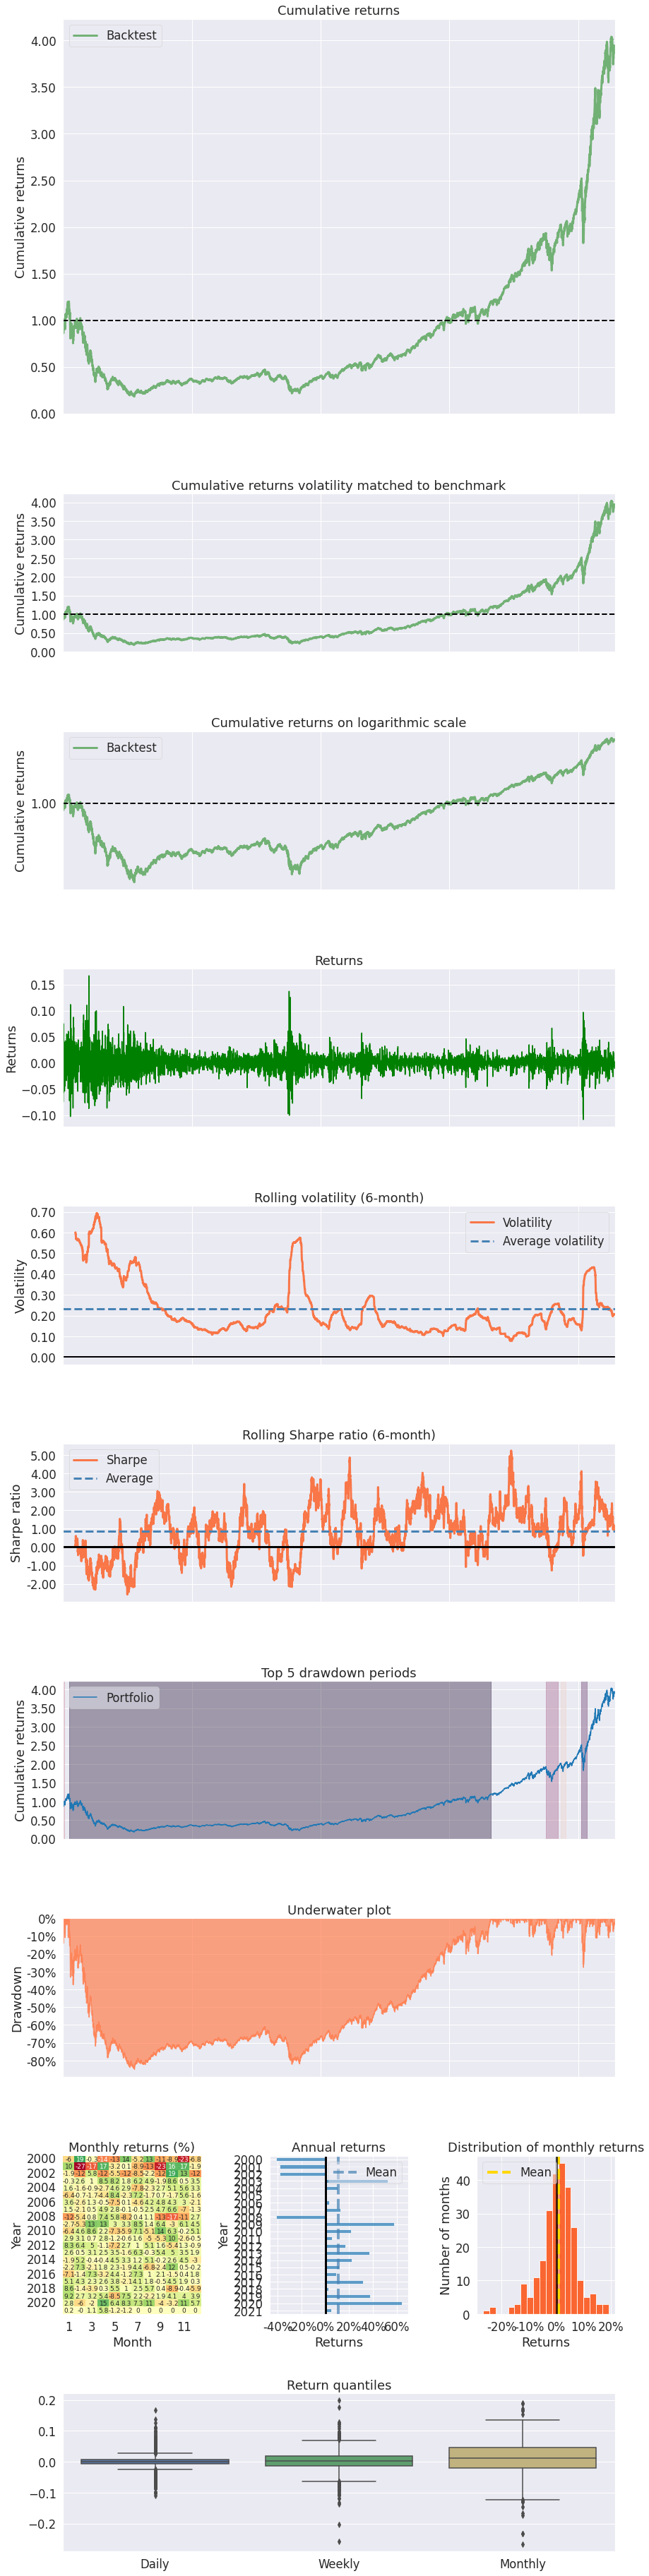

In [71]:
returns = prices.pct_change().fillna(0)    # 가격을 수익률로 변환, 수익률 계산 시 사용한 첫 번째 줄 N/A를 0으로 처리
print(returns)

pf.create_returns_tear_sheet(returns)   # 나스닥 100 지수를 단순보유했을 때 성과

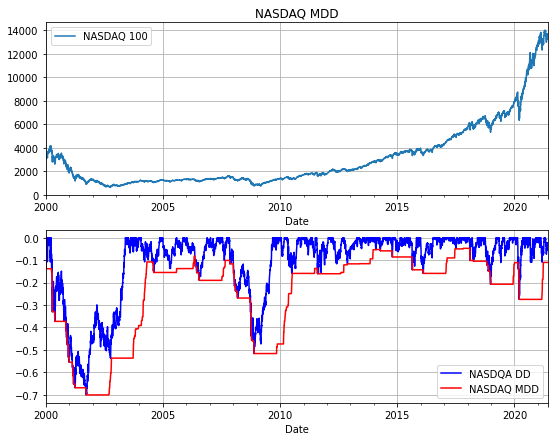

-0.7007917021434571


Date
2001-09-21   -0.700792
2001-09-24   -0.700792
2001-09-25   -0.700792
2001-09-26   -0.700792
2001-09-27   -0.700792
                ...   
2002-09-03   -0.700792
2002-09-04   -0.700792
2002-09-05   -0.700792
2002-09-06   -0.700792
2002-09-09   -0.700792
Name: Nasdaq 100 Index, Length: 252, dtype: float64

In [ ]:
nasdaq = prices

window = 252    # 1년 동안의 개장일을 252일로 어림잡아 설정
peak = nasdaq.rolling(window, min_periods=1).max()    # 1년 기간 단위로 최고치를 산출
drawdown = nasdaq/peak - 1.0    # drawdown은 최고치 대비 현재 NASDAQ이 얼마나 하락했는지 산출
max_dd = drawdown.rolling(window, min_periods=1).min()

plt.figure(figsize=(9, 7))
plt.subplot(211)
nasdaq.plot(label='NASDAQ 100', title='NASDAQ MDD', grid=True, legend=True)
plt.subplot(212)
drawdown.plot(c='blue', label='NASDQA DD', grid=True, legend=True)
max_dd.plot(c='red', label='NASDAQ MDD', grid=True, legend=True)
plt.show()

print(max_dd.min())
max_dd[max_dd==-0.7007917021434571]   # 2001-09-21 ~ 2002-09-09 까지 약 1년간 주어진 MDD


3. 누적 수익률 계산

In [ ]:
holding_period = 30   # holding_period parameter 30 설정 (포지션 진입 시 해당 포지션을 유지하게 되는 기간)

def get_holding_returns(prices, holding_period):
  holding_returns = prices.pct_change(periods=holding_period).shift(-holding_period).fillna(0)    # trading signal과 수익률을 inline시키기 위해 holding period만큼 앞으로 당긴다.
  return holding_returns

holding_returns = get_holding_returns(prices, holding_period)  

4. 모멘텀 시그널 - 절대 모멘텀

In [ ]:
lookback = 180    # lookback parameter 180 설정 -> 6개월 전 가격이랑 현재 가격으로 비교해서 모멘텀 시그널 산출

def absolute_momentum(prices, lookback, long_only=False):   # 절대 모멘텀, long/short P/F
    returns = prices.pct_change(periods=lookback).fillna(0)
    long_signal = (returns > 0) * 1   # long 시그널
    short_signal = (returns < 0) * -1   # short 시그널

    if long_only == True:
        signal = long_signal
    else:
        signal = long_signal + short_signal
    return signal

signal = absolute_momentum(prices, lookback)   


5. 최종 성과에 대한 그래프

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,13.653%
Cumulative returns,1609.804%
Annual volatility,4.039%
Sharpe ratio,3.19
Calmar ratio,0.40
Stability,0.89
Max drawdown,-33.821%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.82,2004-01-02,2008-04-30,2008-10-20,1252
1,24.23,2009-02-06,2009-06-10,2010-02-19,271
2,23.48,2001-09-10,2001-12-17,2002-05-02,169
3,18.68,2002-09-02,2002-10-31,2003-07-23,233
4,17.32,2015-07-09,2016-03-11,2017-02-24,427


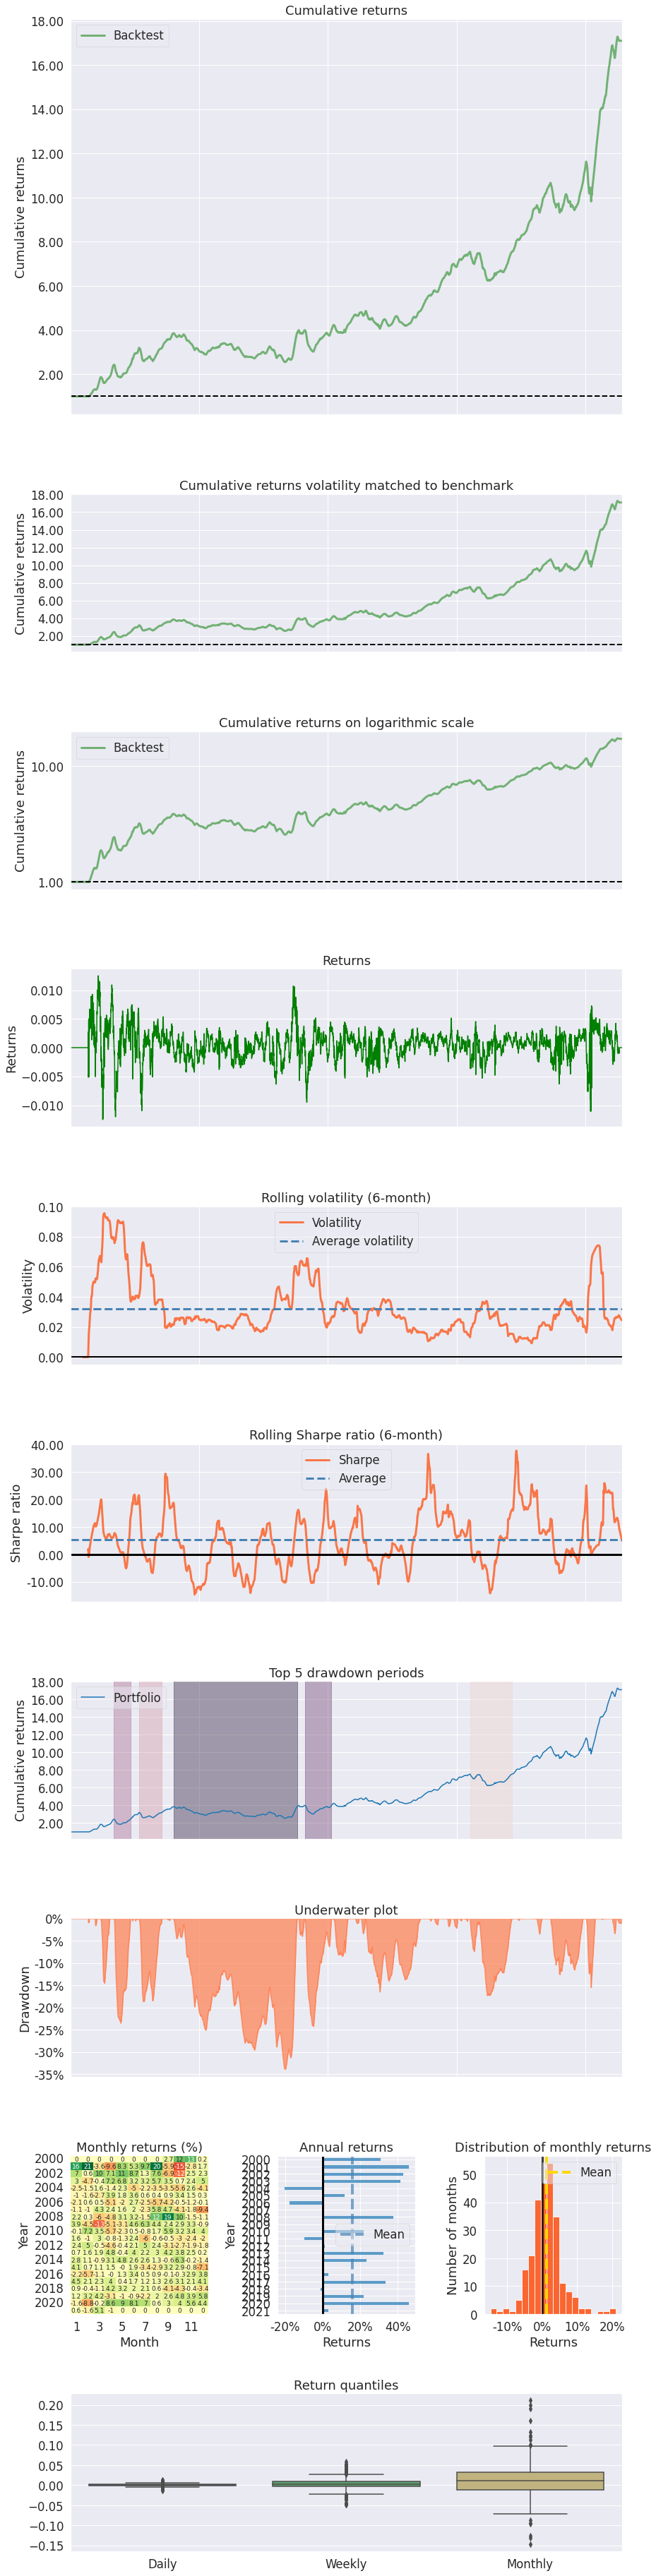

In [66]:
# 리밸런싱 비중 = 리밸런싱 주기 / 홀딩 기간
rebalance_weight = 1 / holding_period   # 리밸런싱 주기보다 홀딩기간이 길어지면, 각 진입시점마다 자금을 분할해서 투입

cost = 0.001
cost_df = (signal.diff() != 0) * cost   # 시그널 변동이 있을 때마다(매수, 매도 진입 & 청산) 거래비용 적용
cost_df.iloc[0] = 0 

single_asset_returns = (signal * holding_returns - cost_df) * rebalance_weight    # 거래비용 감안해서 signal을 따라 매매한 수익률의 결과
pf.create_returns_tear_sheet(single_asset_returns)






<B&H와 Momentum 전략의 상관계수>


0.0036497296565298843

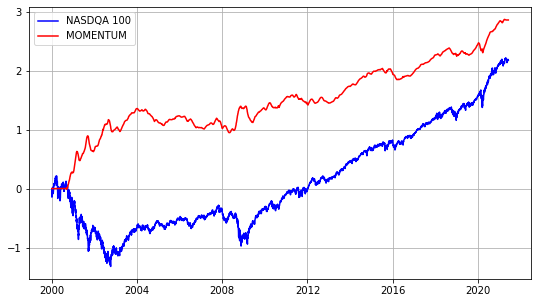

In [73]:
returns_cs = returns.cumsum()


single_asset_returns_cs = single_asset_returns.cumsum()


plt.figure(figsize=(9, 5))
plt.plot(returns_cs.index, returns_cs, 'b', label = 'NASDQA 100')
plt.plot(single_asset_returns_cs.index, single_asset_returns_cs, 'r', label='MOMENTUM')
plt.grid(True)
plt.legend(loc='best')
plt.show

print("<B&H와 Momentum 전략의 상관계수>")
returns.corr(single_asset_returns)